In [73]:
import os
import pandas as pd

modality = {'01': 'full-AV', '02': 'video-only', '03': 'audio-only'}
vocal_channel = {'01': 'speech', '02': 'song'}
emotion = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
intensity = {'01': 'normal', '02': 'strong'}
statement = {'01': 'Kids are talking by the door', '02': 'Dogs are sitting by the door'}
repetition = {'01': '1st repetition', '02': '2nd repetition'}

data = []

base_path = "../Dataset"  

for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)
    if not os.path.isdir(actor_path):
        continue
    
    for filename in os.listdir(actor_path):
        if not filename.lower().endswith('.wav'):
            continue
        
        parts = filename.split('.')[0].split('-')
        if len(parts) != 7:
            continue
        
        file_info = {
            'Filename': filename,
            'Modality': modality.get(parts[0]),
            'Vocal Channel': vocal_channel.get(parts[1]),
            'Emotion': emotion.get(parts[2]),
            'Intensity': intensity.get(parts[3]),
            'Statement': statement.get(parts[4]),
            'Repetition': repetition.get(parts[5]),
            'Actor': int(parts[6]),
            'Gender': 'male' if int(parts[6]) % 2 == 1 else 'female'
        }
        data.append(file_info)

df = pd.DataFrame(data)
df.head()

,Filename,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor,Gender
0,03-02-01-01-01-01-01.wav,audio-only,song,neutral,normal,Kids are talking by the door,1st repetition,1,male
1,03-02-01-01-01-02-01.wav,audio-only,song,neutral,normal,Kids are talking by the door,2nd repetition,1,male
2,03-02-01-01-02-01-01.wav,audio-only,song,neutral,normal,Dogs are sitting by the door,1st repetition,1,male
3,03-02-01-01-02-02-01.wav,audio-only,song,neutral,normal,Dogs are sitting by the door,2nd repetition,1,male
4,03-02-02-01-01-01-01.wav,audio-only,song,calm,normal,Kids are talking by the door,1st repetition,1,male


# EDA

In [74]:
df.isnull().sum()

Filename         0
Modality         0
Vocal Channel    0
Emotion          0
Intensity        0
Statement        0
Repetition       0
Actor            0
Gender           0
dtype: int64

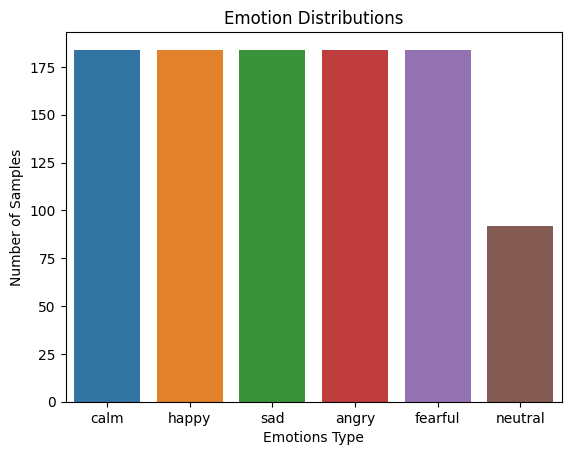

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.Figure(figsize=(10,5))
sns.countplot(x='Emotion', data=df, order=df['Emotion'].value_counts().index)
plt.title('Emotion Distributions')
plt.xlabel('Emotions Type')
plt.ylabel('Number of Samples')
plt.show()

In [76]:
emotions_count = df['Emotion'].value_counts(normalize=True) * 100

print(emotions_count.round(2))

Emotion
calm       18.18
happy      18.18
sad        18.18
angry      18.18
fearful    18.18
neutral     9.09
Name: proportion, dtype: float64


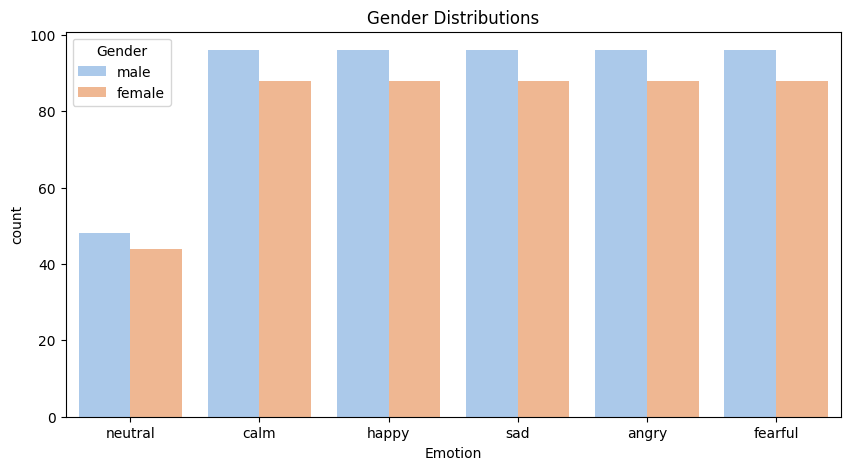

In [77]:
plt.figure(figsize=(10,5))
sns.countplot(x='Emotion', hue='Gender' ,data=df, palette='pastel')
plt.title('Gender Distributions')
plt.show()

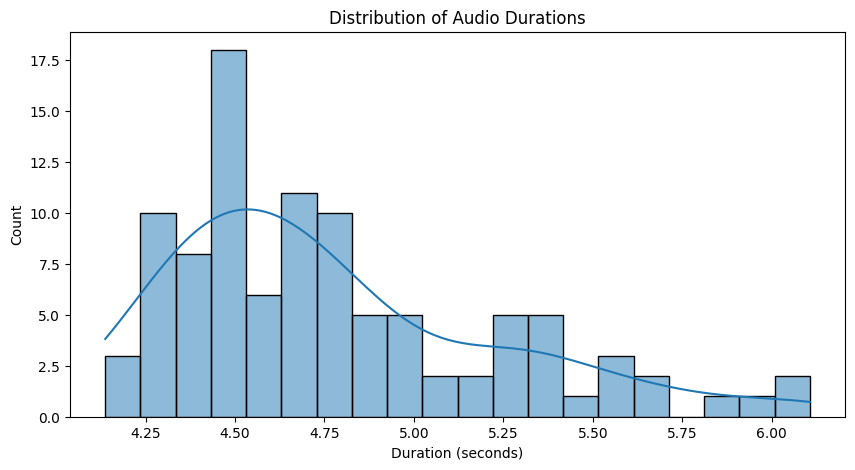

In [78]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

durations = []
df['Actor'] = df['Actor'].astype(int)

for _, row in df.iloc[:100].iterrows():
  actor_num = int(row['Actor'])
  filename = row['Filename']
  actor_folder = f"Actor_{actor_num:02d}"
  file_path = os.path.join(base_path, actor_folder, filename)
  
  if not os.path.isfile(file_path):
    print("File not found, skip:", file_path)
    continue
  
  try:
    y, sr = librosa.load(file_path, sr=None)  
    dur = librosa.get_duration(y=y, sr=sr)
    durations.append(dur)
  except Exception as e:
    print("Error loading", file_path, "-", str(e))
    continue

plt.figure(figsize=(10,5))
sns.histplot(durations, bins=20, kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()


In [79]:
df.columns

Index(['Filename', 'Modality', 'Vocal Channel', 'Emotion', 'Intensity',
       'Statement', 'Repetition', 'Actor', 'Gender'],
      dtype='object')

# Preprocessing

In [80]:
import seaborn as sns
import librosa, librosa.display
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [81]:
df['Actor'] = df['Actor'].astype(int)
df['path'] = df.apply(lambda r: os.path.join(base_path, f"Actor_{int(r['Actor']):02d}", r['Filename']), axis=1)

print("Total Files: ", len(df))
print(df['Emotion'].value_counts())
print(df[['Actor', 'Gender']].value_counts())

Total Files:  1012
Emotion
calm       184
happy      184
sad        184
angry      184
fearful    184
neutral     92
Name: count, dtype: int64
Actor  Gender
1      male      44
13     male      44
23     male      44
22     female    44
21     male      44
20     female    44
19     male      44
17     male      44
16     female    44
15     male      44
14     female    44
12     female    44
2      female    44
11     male      44
10     female    44
9      male      44
8      female    44
7      male      44
6      female    44
5      male      44
4      female    44
3      male      44
24     female    44
Name: count, dtype: int64


In [82]:
SR = 16000
N_Mels = 128
Target_Width = 128

def load_audio(path, sr=SR):
  y,_ = librosa.load(path, sr=sr)
  y,_ = librosa.effects.trim(y)
  return y

def wav_to_mel(path, sr=SR, n_mels = N_Mels, target_width = Target_Width):
  try:
    y = load_audio(path, sr)
  except:
    return None
  
  S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
  S_db = librosa.power_to_db(S, ref=np.max)

  if S_db.shape[1] < target_width:
    pad_width = target_width - S_db.shape[1]
    S_db = np.pad(S_db, ((0,0), (0, pad_width)), mode='constant')
  else:
    S_db = S_db[:, :target_width]
  
  S_Norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-6)

  img = S_Norm.astype(np.float32)
  # make it into 3 channel to fix the VGG requirement
  img3 = np.stack([img, img, img], axis = -1)
  return img3

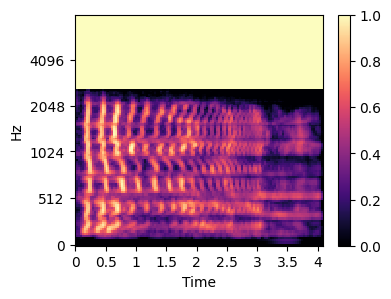

In [83]:
sample_img = wav_to_mel(df['path'].iloc[0])
plt.figure(figsize=(4,3)); librosa.display.specshow(sample_img[:,:,0].T, sr=SR, x_axis='time', y_axis='mel'); plt.colorbar(); plt.show()

Dari pola garis-garis horizontal yang jelas, bisa disimpulkan ini adalah suara bernada yang stabil, seperti vokal manusia yang sedang bernyanyi atau alat musik yang dimainkan.

Apakah Baik untuk Machine Learning (Segmentasi Audio)?
Ya, audio ini sangat baik untuk melatih model machine learning untuk tugas segmentasi audio.

Alasannya:

Sinyal Sangat Jernih: Suaranya sangat jelas dan bersih dari noise (gangguan). Ini memudahkan model untuk mengenali pola utamanya.

Fitur Stabil: Karakteristik suara (pola garis-garisnya) konsisten selama 4 detik, menjadikannya contoh yang ideal untuk dipelajari oleh AI.

Batas yang Jelas: Suara dimulai dan berlangsung dengan jelas, sehingga sempurna untuk melatih model dalam mendeteksi kapan sebuah segmen audio dimulai dan berakhir.

In [84]:
labels = df['Emotion'].values
le = LabelEncoder()
y_all = le.fit_transform(labels)
num_classes = len(le.classes_)

x_list = []
y_list = []
for p, lab in zip(df['path'], y_all):
  img = wav_to_mel(p)
  if img is None:
    continue
  x_list.append(img)
  y_list.append(lab)

x = np.stack(x_list)
y = np.array(y_list)
print(x.shape, y.shape)

(1012, 128, 128, 3) (1012,)


# Training 

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

print(x_train.shape, x_val.shape, x_test.shape)

(728, 128, 128, 3) (81, 128, 128, 3) (203, 128, 128, 3)


In [86]:
def add_noise(y, noise_factor = 0.005):
  noise = np.random(len(y))
  return y + noise_factor * noise

def pitch_shift(y, sr, n_steps = 2):
  return librosa.effects.pitch_shift(y, sr, n_steps)

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True
)

datagen.fit(x_train)

In [98]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Reshape, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_shape = (N_Mels, Target_Width, 3)
base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base.layers[:-12]:
  layer.trainable = False

x = base.output
# x = Reshape((-1, x.shape[-1]))(x)
# x = Attention()([x, x])
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation = 'softmax', dtype = 'float32')(x)

model = Model(inputs=base.input, outputs = out)
model.compile(
  optimizer = Adam(learning_rate=1e-5),
  loss = 'sparse_categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [99]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('vgg_head.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', patience=8, restore_best_weights=True)
ReduceLRON = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 4, min_lr = 1e-7)

history = model.fit(
  x_train, y_train,
  validation_data = (x_val, y_val),
  epochs = 30,
  batch_size = 16,
  callbacks = [checkpoint, early_stop, ReduceLRON]
)

Epoch 1/30
46/46 [==============================] - 8s 141ms/step - loss: 1.8959 - accuracy: 0.2747 - val_loss: 1.7183 - val_accuracy: 0.2346 - lr: 1.0000e-05
Epoch 2/30
46/46 [==============================] - 6s 135ms/step - loss: 1.5441 - accuracy: 0.3984 - val_loss: 1.6623 - val_accuracy: 0.2963 - lr: 1.0000e-05
Epoch 3/30
46/46 [==============================] - 6s 133ms/step - loss: 1.3054 - accuracy: 0.4863 - val_loss: 1.6028 - val_accuracy: 0.4198 - lr: 1.0000e-05
Epoch 4/30
46/46 [==============================] - 6s 135ms/step - loss: 1.1415 - accuracy: 0.5728 - val_loss: 1.5369 - val_accuracy: 0.4938 - lr: 1.0000e-05
Epoch 5/30
46/46 [==============================] - 6s 129ms/step - loss: 1.0276 - accuracy: 0.6415 - val_loss: 1.4465 - val_accuracy: 0.4444 - lr: 1.0000e-05
Epoch 6/30
46/46 [==============================] - 6s 128ms/step - loss: 0.8467 - accuracy: 0.6992 - val_loss: 1.3460 - val_accuracy: 0.4938 - lr: 1.0000e-05
Epoch 7/30
46/46 [============================

# Evalution

7/7 [==============================] - 1s 102ms/step - loss: 0.6362 - accuracy: 0.7783
test accuracy:  0.7783251404762268
7/7 [==============================] - 1s 111ms/step
              precision    recall  f1-score   support

       angry       0.89      0.86      0.88        37
        calm       0.79      0.92      0.85        37
     fearful       0.65      0.89      0.75        37
       happy       0.70      0.70      0.70        37
     neutral       0.88      0.83      0.86        18
         sad       0.95      0.49      0.64        37

    accuracy                           0.78       203
   macro avg       0.81      0.78      0.78       203
weighted avg       0.80      0.78      0.77       203



<Figure size 800x600 with 0 Axes>

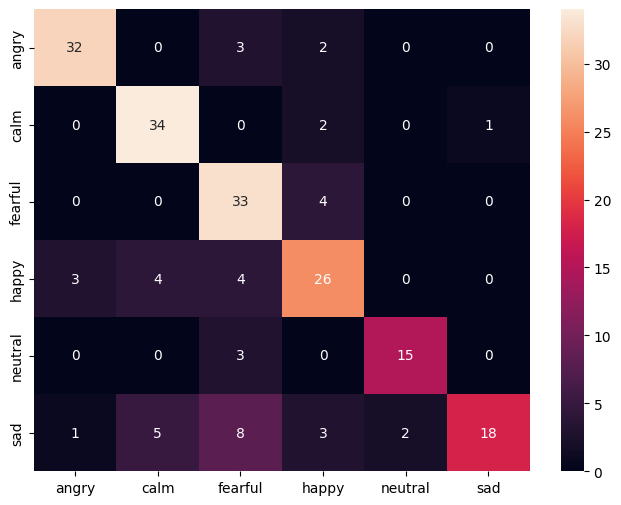

In [100]:
model.load_weights('vgg_head.h5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)
print("test accuracy: ", test_acc)

y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Confusion_Matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6)); sns.heatmap(Confusion_Matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

# Tuning

In [101]:
checkpoint = ModelCheckpoint('vgg_head.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', patience=6, restore_best_weights=True)
ReduceLRON = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-7)

In [102]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, callbacks = [checkpoint, early_stop, ReduceLRON])

Epoch 1/30
46/46 [==============================] - 6s 137ms/step - loss: 0.0772 - accuracy: 0.9973 - val_loss: 0.8255 - val_accuracy: 0.7407 - lr: 2.5000e-06
Epoch 2/30
46/46 [==============================] - 6s 128ms/step - loss: 0.0734 - accuracy: 0.9931 - val_loss: 0.8160 - val_accuracy: 0.7284 - lr: 2.5000e-06
Epoch 3/30
46/46 [==============================] - 6s 128ms/step - loss: 0.0770 - accuracy: 0.9959 - val_loss: 0.8050 - val_accuracy: 0.7160 - lr: 2.5000e-06
Epoch 4/30
46/46 [==============================] - 6s 128ms/step - loss: 0.0707 - accuracy: 0.9918 - val_loss: 0.8188 - val_accuracy: 0.7407 - lr: 2.5000e-06
Epoch 5/30
46/46 [==============================] - 6s 127ms/step - loss: 0.0627 - accuracy: 0.9973 - val_loss: 0.8284 - val_accuracy: 0.6914 - lr: 2.5000e-06
Epoch 6/30
46/46 [==============================] - 6s 128ms/step - loss: 0.0551 - accuracy: 0.9973 - val_loss: 0.7958 - val_accuracy: 0.7407 - lr: 2.5000e-06
Epoch 7/30
46/46 [============================

In [103]:
test_loss, test_acc = model.evaluate(x_test, y_test)

y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = y_test

emotion_labels = ['angry', 'calm', 'fearful', 'happy', 'neutral', 'sad']
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print(classification_report(y_true, y_pred_classes, target_names=emotion_labels))

7/7 [==============================] - 1s 111ms/step
Test Loss: 0.6381027698516846
Test Accuracy: 0.7980295419692993
              precision    recall  f1-score   support

       angry       0.85      0.92      0.88        37
        calm       0.81      0.92      0.86        37
     fearful       0.66      0.84      0.74        37
       happy       0.74      0.70      0.72        37
     neutral       0.94      0.89      0.91        18
         sad       0.95      0.57      0.71        37

    accuracy                           0.80       203
   macro avg       0.83      0.81      0.81       203
weighted avg       0.82      0.80      0.79       203



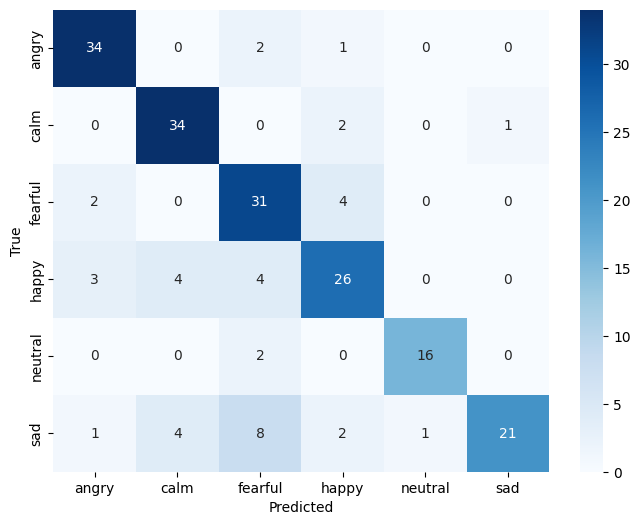

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [105]:
import numpy as np, collections
print("Support true:", np.bincount(y_true))
print("Support pred:", np.bincount(y_pred_classes))

Support true: [37 37 37 37 18 37]
Support pred: [40 42 47 35 17 22]
